In [11]:
import yfinance as yf

#Descarga de datos de Yahoo Finance

aapl_data = yf.download('AAPL', start='2020-01-01', end='2023-12-31')

/home/albertocastrovill/Documents/UDEM/IA2/IA2_venv/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [12]:
print(aapl_data.head(5))
print(aapl_data.tail(5))

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  73.059433  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.349136  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.925629  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.582657  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.750244  132079200
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-12-22  195.179993  195.410004  192.970001  193.600006  193.353287   
2023-12-26  193.610001  193.889999  192.830002  193.050003  192.803986   
2023-12-27  192.490005  193.500000  191.089996  193.149994  192.903839   
2023-12-28  194.139999  194.660004  193.169998  193.580002  193.333298   
2023-12-29  193.8

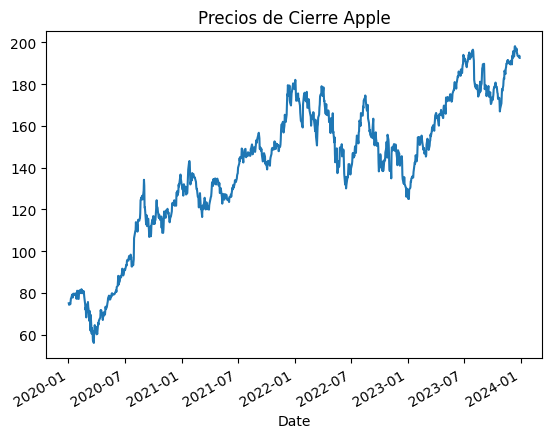

In [13]:
import matplotlib.pyplot as plt

close_prices = aapl_data['Close']
close_prices.plot()
plt.title('Precios de Cierre Apple')
plt.show()

In [14]:
#El gráfico muentra una serie no estacionaria, es decir, presenta tendencia.
# Realizamos el test de Dickey-Fuller para confirmar que la serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

test = adfuller(close_prices)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])

if test[1] > 0.05:
    print('La serie es no estacionaria (tiene tendencia)')
else:
    print('La serie es estacionaria (no tiene tendencia)')



#El p-value es mayor a 0.05, por lo que rechazamos la hipótesis aceptamos y concluimos que la serie es estacionaria.


ADF Statistic: -1.555344
p-value: 0.505978
La serie es no estacionaria (tiene tendencia)


In [15]:
# Hayamos la primera diferencia de la serie de precios de cierre.

y_diff = close_prices.diff().dropna()

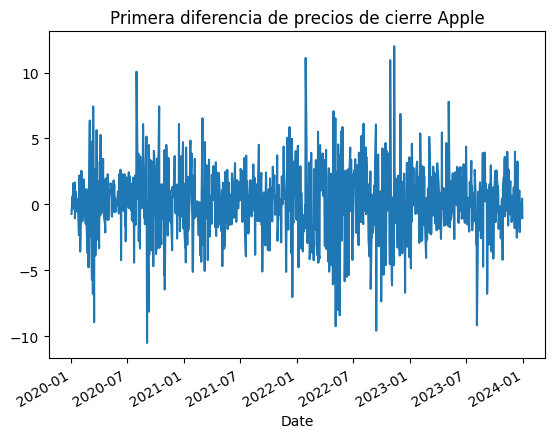

In [16]:
# Graficamos la serie resultante
y_diff.plot()
plt.title('Primera diferencia de precios de cierre Apple')
plt.show()

In [17]:
test_diff = adfuller(y_diff)
print('ADF Statistic: %f' % test_diff[0])
print('p-value: %f' % test_diff[1])

if test_diff[1] > 0.05:
    print('La serie es no estacionaria (tiene tendencia)')
else:
    print('La serie es estacionaria (no tiene tendencia)')

ADF Statistic: -33.004757
p-value: 0.000000
La serie es estacionaria (no tiene tendencia)


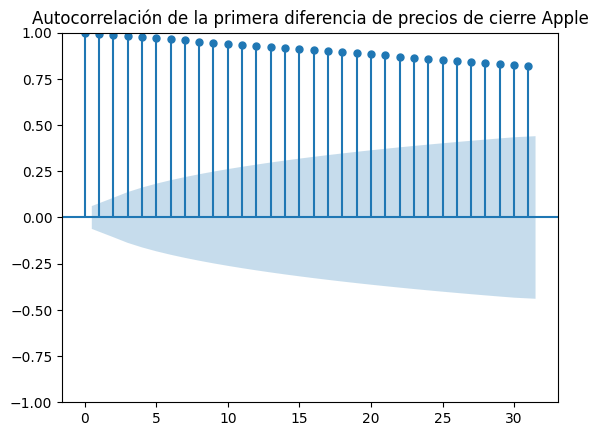

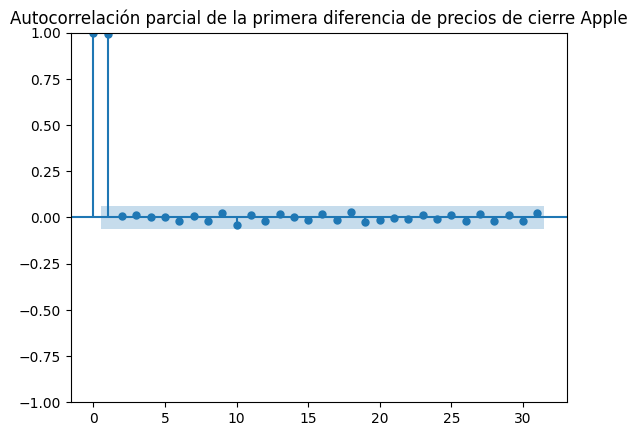

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficamos la función de autocorrelación MA
plot_acf(close_prices.dropna()) 
plt.title('Autocorrelación de la primera diferencia de precios de cierre Apple')
plt.show()

# Graficamos la función de autocorrelación parcial AR
plot_pacf(close_prices.dropna())
plt.title('Autocorrelación parcial de la primera diferencia de precios de cierre Apple')
plt.show()

In [19]:
import warnings
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller 
import numpy as np
#ignorar advertencias
warnings.filterwarnings("ignore")

#generamos la funcion optima
def optimal_d(series):
  d=0
  p_value=adfuller(series)[1]
  while p_value > 0.05:
    d += 1
    p_value = adfuller(np.diff(series,n=d))[1]
  return d

d_optimal = optimal_d(close_prices)

#funcion para evaluar AR I MA

def evaluar_modelo(dataset, p_values, d, q_values):
  dataset = dataset.astype("float32")
  best_score , best_cf = float("inf"), None
  for p in p_values:
    for q in q_values:
      order = (p,d,q)
      try: 
        model = ARIMA(dataset, order=order)
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_score:
          best_score, best_cf = aic, order
        print("ARIMA%s AIC%.3f" %(order,aic))
      except: 
        continue
  print("BEST MODEL: ARIMA%s AIC%.3f" %(best_cf, best_score))
  return best_cf

#rangos de p q
p_values = range(0,4)
q_values = range(0,4)

#llamamos la funcion
best_order = evaluar_modelo(close_prices, p_values, d_optimal, q_values)
print(f"los valores optimos son: p= {best_order[0]}, d= {best_order[1]}, q= {best_order[2]}")


ARIMA(0, 1, 0) AIC4811.269
ARIMA(0, 1, 1) AIC4811.611
ARIMA(0, 1, 2) AIC4813.146
ARIMA(0, 1, 3) AIC4815.040
ARIMA(1, 1, 0) AIC4811.683
ARIMA(1, 1, 1) AIC4813.129
ARIMA(1, 1, 2) AIC4815.080
ARIMA(1, 1, 3) AIC4813.549
ARIMA(2, 1, 0) AIC4813.193
ARIMA(2, 1, 1) AIC4815.076
ARIMA(2, 1, 2) AIC4817.092
ARIMA(2, 1, 3) AIC4813.260
ARIMA(3, 1, 0) AIC4815.023
ARIMA(3, 1, 1) AIC4817.014
ARIMA(3, 1, 2) AIC4813.354
ARIMA(3, 1, 3) AIC4819.294
BEST MODEL: ARIMA(0, 1, 0) AIC4811.269
los valores optimos son: p= 0, d= 1, q= 0


In [20]:
from statsmodels.tsa.arima.model import ARIMA

#Ajustamos el modelo elegido
model = ARIMA(close_prices, order=(0,1,0))
model_fit = model.fit()

#Resumen
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1006
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2404.635
Date:                Thu, 15 Feb 2024   AIC                           4811.269
Time:                        12:10:46   BIC                           4816.182
Sample:                             0   HQIC                          4813.136
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.0109      0.230     30.418      0.000       6.559       7.463
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):               122.11
Prob(Q):                              0.18   Pr

In [21]:
# Si el modelo esta bien hecho se tiene que rechazr la hipotesis nula de los rezagos ..... P>|z|

In [22]:
#Predicciones
arima_predicciones = model_fit.forecast(steps=15)
print(arima_predicciones)

1006    192.529999
1007    192.529999
1008    192.529999
1009    192.529999
1010    192.529999
1011    192.529999
1012    192.529999
1013    192.529999
1014    192.529999
1015    192.529999
1016    192.529999
1017    192.529999
1018    192.529999
1019    192.529999
1020    192.529999
Name: predicted_mean, dtype: float64


In [23]:
# Creamos la Red Neuronal
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalizamos los datos
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(close_prices).reshape(-1,1))

# Generamos la secuencia
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X,y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0],X.shape[1],1)


In [24]:
#Cremos el modelo LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

#Constriur el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))

model.add(Dense(1)) #Capa de salida unica

#Compilamos el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
#Entrenamos el modelo
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
model.fit(X, y, epochs=80, batch_size=32, callbacks=[early_stop])

Epoch 1/80
29/29 [==============================] - 7s 86ms/step - loss: 0.0544
Epoch 2/80
29/29 [==============================] - 4s 129ms/step - loss: 0.0045
Epoch 3/80
29/29 [==============================] - 3s 110ms/step - loss: 0.0027
Epoch 4/80
29/29 [==============================] - 3s 86ms/step - loss: 0.0020
Epoch 5/80
29/29 [==============================] - 2s 68ms/step - loss: 0.0019
Epoch 6/80
29/29 [==============================] - 2s 71ms/step - loss: 0.0018
Epoch 7/80
29/29 [==============================] - 2s 72ms/step - loss: 0.0017
Epoch 8/80
29/29 [==============================] - 2s 77ms/step - loss: 0.0018
Epoch 9/80
29/29 [==============================] - 2s 69ms/step - loss: 0.0017
Epoch 10/80
29/29 [==============================] - 2s 68ms/step - loss: 0.0018
Epoch 11/80
29/29 [==============================] - 2s 71ms/step - loss: 0.0015
Epoch 12/80
29/29 [==============================] - 2s 79ms/step - loss: 0.0016
Epoch 13/80
29/29 [================

In [26]:
# Hacemos predicciones
prediccion_lstm = model.predict(X)
prediccion_lstm = scaler.inverse_transform(prediccion_lstm)

prediccion_lstm

29/29 [==============================] - 2s 38ms/step


array([[ 80.3925  ],
       [ 80.47048 ],
       [ 80.52355 ],
       [ 80.53352 ],
       [ 80.78347 ],
       [ 81.14453 ],
       [ 81.567566],
       [ 81.709175],
       [ 82.33358 ],
       [ 83.07228 ],
       [ 84.37865 ],
       [ 86.13441 ],
       [ 86.31082 ],
       [ 86.13874 ],
       [ 86.16278 ],
       [ 86.880875],
       [ 87.58132 ],
       [ 88.09396 ],
       [ 88.24511 ],
       [ 88.90519 ],
       [ 90.092545],
       [ 90.60284 ],
       [ 91.115654],
       [ 90.59923 ],
       [ 90.543335],
       [ 90.85132 ],
       [ 91.136566],
       [ 91.338806],
       [ 92.20306 ],
       [ 92.91009 ],
       [ 94.04098 ],
       [ 95.06364 ],
       [ 95.77534 ],
       [ 96.003235],
       [ 96.50895 ],
       [ 97.13048 ],
       [ 97.18504 ],
       [ 96.993225],
       [ 97.447464],
       [ 97.48821 ],
       [ 97.50306 ],
       [ 96.06075 ],
       [ 94.62669 ],
       [ 94.33127 ],
       [ 93.98755 ],
       [ 94.34441 ],
       [ 95.175995],
       [ 99.2

In [27]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [28]:
#Generamos el vector input
data = close_prices.values.reshape(-1,1)

#Escalamos los datos
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

#Dividimos los datos en train y test
split_data = int(len(data_scaled)*0.8)
train = data_scaled[:split_data]
test = data_scaled[split_data:]

#Crear secuencias de tiempo
look_back = 10
train_gen = TimeseriesGenerator(train, train, length=look_back, batch_size=20)
test_gen = TimeseriesGenerator(test, test, length=look_back, batch_size=1)

#Construimos el modelo
model = Sequential()
model.add(GRU(50, input_shape=(look_back,1), return_sequences=True))
model.add(GRU(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compilamos el modelo
model.compile(optimizer='adam', loss='mean_squared_error')




In [29]:
#Entrenamos el modelo
model.fit(train_gen, epochs=50, verbose=1,validation_data=test_gen, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/50
40/40 [==============================] - 10s 92ms/step - loss: 0.0347 - val_loss: 0.0016
Epoch 2/50
40/40 [==============================] - 1s 28ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 3/50
40/40 [==============================] - 1s 26ms/step - loss: 0.0010 - val_loss: 8.6281e-04
Epoch 4/50
40/40 [==============================] - 1s 28ms/step - loss: 8.4361e-04 - val_loss: 7.8945e-04
Epoch 5/50
40/40 [==============================] - 1s 27ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/50
40/40 [==============================] - 1s 31ms/step - loss: 9.3098e-04 - val_loss: 6.0757e-04
Epoch 7/50
40/40 [==============================] - 1s 26ms/step - loss: 7.9880e-04 - val_loss: 5.2039e-04
Epoch 8/50
40/40 [==============================] - 1s 28ms/step - loss: 9.5152e-04 - val_loss: 0.0019
Epoch 9/50
40/40 [==============================] - 1s 27ms/step - loss: 8.9101e-04 - val_loss: 5.1640e-04
Epoch 10/50
40/40 [==============================] - 1s 27ms/step - 

In [32]:
#Hacemos predicciones
pred_GRU = model.predict(test_gen)

#Desescalamos las predicciones
pred_GRU = scaler.inverse_transform(pred_GRU)

#Imprimimos las predicciones
print(pred_GRU)


192/192 [==============================] - 1s 7ms/step
[[160.46527]
 [159.67644]
 [161.81319]
 [163.57388]
 [165.89102]
 [167.39195]
 [167.30472]
 [165.84311]
 [166.1771 ]
 [164.30302]
 [162.92366]
 [162.09184]
 [166.00064]
 [166.73366]
 [166.85478]
 [167.804  ]
 [168.91017]
 [168.41245]
 [167.0408 ]
 [166.96208]
 [165.78935]
 [165.50455]
 [168.97118]
 [170.78217]
 [171.07504]
 [170.30421]
 [169.29123]
 [167.8102 ]
 [173.41437]
 [174.69807]
 [173.5557 ]
 [174.65952]
 [175.06912]
 [174.23373]
 [173.66199]
 [173.5523 ]
 [174.01794]
 [175.94603]
 [176.4444 ]
 [175.77495]
 [173.58035]
 [173.33423]
 [174.20341]
 [176.2874 ]
 [178.1787 ]
 [178.50671]
 [180.76045]
 [181.89516]
 [181.01582]
 [180.53534]
 [179.36758]
 [181.29549]
 [182.01527]
 [184.35846]
 [184.4279 ]
 [184.91185]
 [186.63524]
 [186.09299]
 [186.04022]
 [185.20743]
 [187.46628]
 [187.65195]
 [186.53175]
 [188.53963]
 [189.87964]
 [190.36646]
 [193.94519]
 [193.34949]
 [192.28801]
 [192.50381]
 [191.6535 ]
 [189.84752]
 [189.122

In [52]:
#Reducimos la dimensionalidad de las predicciones
pred_GRU = pred_GRU.reshape(-1,1)
prediccion_lstm = prediccion_lstm.reshape(-1,1)


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Creamos un dataframe con las predicciones
df_compa = pd.DataFrame({
    "Precios Reales": close_prices,
    "Predicciones ARIMA": arima_predicciones,
    
})

#Visualizar tabla completa
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(df_compa)




                     Precios Reales  Predicciones ARIMA
2020-01-02 00:00:00       75.087502                 NaN
2020-01-03 00:00:00       74.357498                 NaN
2020-01-06 00:00:00       74.949997                 NaN
2020-01-07 00:00:00       74.597504                 NaN
2020-01-08 00:00:00       75.797501                 NaN
2020-01-09 00:00:00       77.407501                 NaN
2020-01-10 00:00:00       77.582497                 NaN
2020-01-13 00:00:00       79.239998                 NaN
2020-01-14 00:00:00       78.169998                 NaN
2020-01-15 00:00:00       77.834999                 NaN
2020-01-16 00:00:00       78.809998                 NaN
2020-01-17 00:00:00       79.682503                 NaN
2020-01-21 00:00:00       79.142502                 NaN
2020-01-22 00:00:00       79.425003                 NaN
2020-01-23 00:00:00       79.807503                 NaN
2020-01-24 00:00:00       79.577499                 NaN
2020-01-27 00:00:00       77.237503             

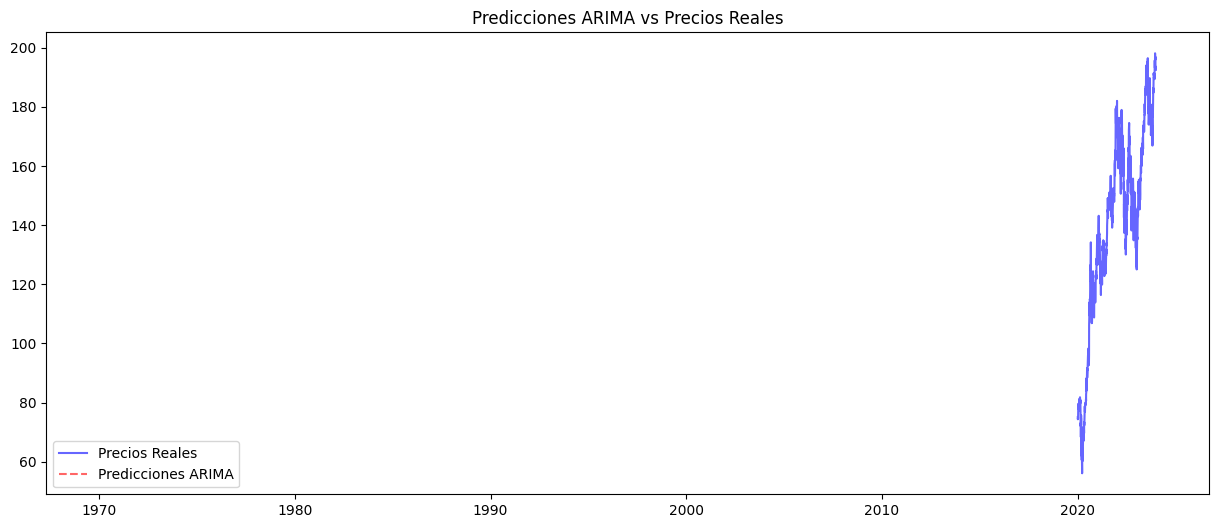

In [59]:
#Visualizamos las predicciones
plt.figure(figsize=(15,6))
plt.plot(df_compa["Precios Reales"], label="Precios Reales", color="blue", alpha=0.6)
plt.plot(df_compa["Predicciones ARIMA"], label="Predicciones ARIMA", color="red", linestyle="--", alpha=0.6)
plt.title("Predicciones ARIMA vs Precios Reales")
plt.legend()
plt.show()
